<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/u2netp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U<sup>2</sup>-Net (U-Square Net)を利用した葉領域抽出

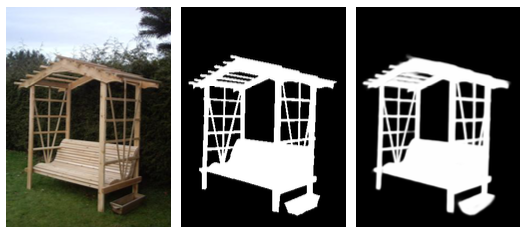

左から入力画像、真値、U<sup>2</sup>-Netによる推論結果<sup>1</sup>

## U<sup>2</sup>-Netとは
U<sup>2</sup>-Netは、2020年にPattern Recognitionで発表された論文において提唱されたモデルです。主な用途として、画像中の主要なオブジェクト（salient object）の検出が挙げられます。公式レポジトリ<sup>2</sup>はApache 2.0ライセンスで公開されており、このモデルを使用して、U2-Netを基にした多くの興味深いアプリケーションやツールが開発されています。

今回は、そのうちの１つであるrembg<sup>3</sup>を紹介します。公式実装のpytorchモデルをonnxに変換し、pipでインストール可能なパッケージとして配布しされています。なお、rembg自体にはMITライセンスが付与されています。

以下の画像についてU<sup>2</sup>-Netを適用してみましょう。植物に特化して訓練されたモデルではありませんが、画像中のsalient objectが植物であれば単離できる可能性は高いと推察されます。


<center>
<img src="https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/imgs/Arabidopsis_arenosa_kz01.jpeg?raw=true" width=25%>

WIKIMEDIA COMMONS<sup>4</sup>. CC-BY-SA 4.0.
</center>

## 基本的な使い方

In [ ]:
'''
rembgライブラリをインストールします。
2023年６月現在、rembgはcpu動作版とgpu動作版が提供されています。
必要に応じインストールするバージョンを切り替えてください。
'''

# !pip install rembg >/dev/null 2>&1  # cpu
!pip install rembg[gpu] >/dev/null 2>&1  # gpu

In [ ]:
import cv2
from rembg import remove
from IPython.display import Image, display
import numpy as np

In [ ]:
# jupyter notebookで画像を表示させるための関数。matplotlibのplt.imshowを使ってもらっても構いません。
def show_image(img):
    _, img = cv2.imencode(".jpg",img)
    display(Image(data=img))

In [ ]:
!wget https://raw.githubusercontent.com/phytometrics/plant_phenotyping_python/main/notebooks/imgs/Arabidopsis_arenosa_kz01.jpeg

--2023-06-10 08:36:20--  https://raw.githubusercontent.com/phytometrics/plant_phenotyping_python/main/notebooks/imgs/Arabidopsis_arenosa_kz01.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79390 (78K) [image/jpeg]
Saving to: ‘Arabidopsis_arenosa_kz01.jpeg.2’

Arabidopsis_arenosa 100%[===================>]  77.53K  --.-KB/s    in 0.007s  

2023-06-10 08:36:20 (11.0 MB/s) - ‘Arabidopsis_arenosa_kz01.jpeg.2’ saved [79390/79390]



--2023-06-10 08:38:27--  https://raw.githubusercontent.com/phytometrics/plant_phenotyping_python/main/notebooks/imgs/Arabidopsis_arenosa_kz01.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79390 (78K) [image/jpeg]
Saving to: ‘image_1.jpg’

image_1.jpg         100%[===================>]  77.53K  --.-KB/s    in 0.005s  

2023-06-10 08:38:27 (16.7 MB/s) - ‘image_1.jpg’ saved [79390/79390]

(341, 512, 3)


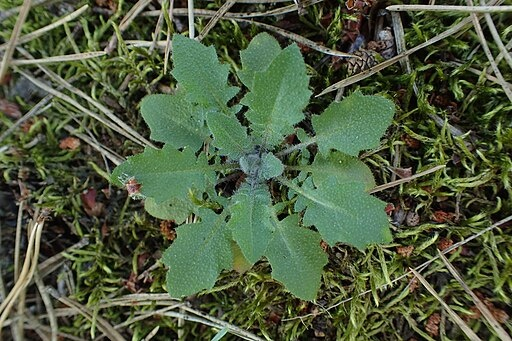

In [ ]:
# 画像の取得
image_url_1 = 'https://raw.githubusercontent.com/phytometrics/plant_phenotyping_python/main/notebooks/imgs/Arabidopsis_arenosa_kz01.jpeg'
!wget -O image_1.jpg {image_url_1}
image = cv2.imread("image_1.jpg")
print(image.shape)
show_image(image)

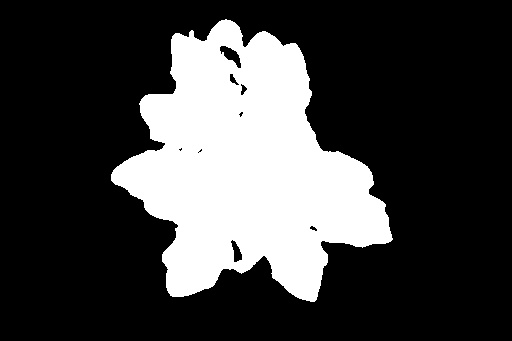

CPU times: user 2.42 s, sys: 313 ms, total: 2.73 s
Wall time: 1.15 s


In [ ]:
# 処理時間計測
%%time 

# 背景除去
mask = remove(
    image,
    only_mask=True)

# 0-255の輝度の値のうち、125を閾値にしてbool型に変換する。
mask = mask > 125

# bool型をuint8型（0-255）に戻す。
mask = mask.astype(np.uint8) * 255

# 画像を表示する。
show_image(mask)

## Citation

1. U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection, Qin et al., Pattern Recognition 2022.

2. https://github.com/xuebinqin/U-2-Net

3. https://github.com/danielgatis/rembg

4. https://commons.wikimedia.org/wiki/File:Arabidopsis_arenosa_kz01.jpg